# Navier Stokes solver

This notebook contains the solution of the Navier Stokes equations, solved using Chorin's projection.

This notebook solves the classic Lid driven cavity, in which a fluid is moved due to a boundary condition, as seen on the following figure

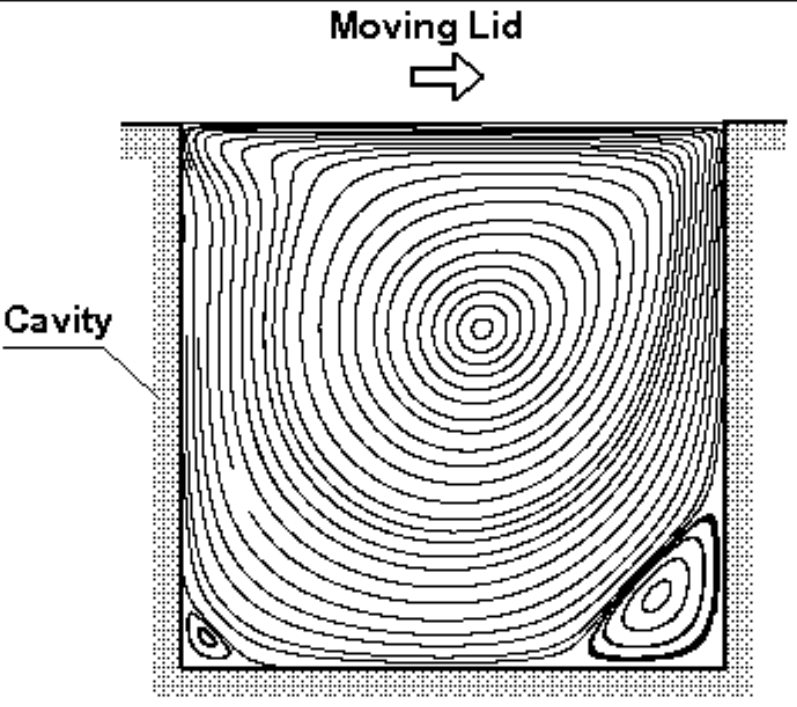

In [ ]:
#Setup FeniCs, only works on Colab

!wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
import dolfin
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

In [3]:
pip install meshio

In [ ]:
msh = meshio.read("splinesElectrospinning.msh") #Read mesh, if needed
meshio.write("splinesElectrospinning.xml",msh)
mesh = Mesh("splinesElectrospinning.xml")

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

In [ ]:
from matplotlib.cbook import normalize_kwargs
#SelfImplemented Navier-Stokes Problem with Chorin Proj IPCS
import meshio
from dolfin import *

#Creation of a unitSquareMesh, for simplicity
mesh = UnitSquareMesh(50,50)

#Define Taylor-Hood elements (For now, they work best for Navier-Stokes problems)
V = VectorFunctionSpace(mesh, 'P', 2) #Function space that solves for velocity
Q = FunctionSpace(mesh, 'P', 1) #Function space that solves for pressure

#Define Two sets of Test/Trial functions, as we are working with two unknowns.
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

def up_boundary(x, on_boundary):  #Establish the parts of the boundary where boundary conditions will be applied
  return(on_boundary and near(x[1],1))

def down_boundary(x, on_boundary):
  return(on_boundary and near(x[1],0))

def left_boundary(x, on_boundary):
  return(on_boundary and near(x[0],0))

def right_boundary(x, on_boundary):
  return(on_boundary and near(x[0],1))

def pressureCond(x, on_boundary):  #If we want to work with an outflow at the bottom, this condition must be enforced, otherwise, it is not needed
  return(on_boundary and near(x[1], 0))


DBup = DirichletBC(V, Constant((-1,0)) , up_boundary)  #Note that constants must be two dimentional
DBdown = DirichletBC(V, Constant((0,0)) , down_boundary)
DBleft = DirichletBC(V, Constant((0,0)) , left_boundary)
DBright = DirichletBC(V, Constant((0,0)) , right_boundary)
DBcond = DirichletBC(Q, Constant(0) , pressureCond)

bcs = [DBup, DBleft, DBright, DBdown] #Add all Dirichlet BC into a list
bcs2 = [] #Add DBcond if working with an outflow

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

#Formulation of the variational form of NavierStokes

#Parameter Creation

T = 1      # final time
num_steps = 300  # number of time steps
dt = T / num_steps # time step size
mu = 0.1     # dynamic viscosity
rho = 1            # density

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh) #Creation of normal to the Facets
f  = Constant((0,0))  #External Forces
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)  #Integers must be changed into constant type

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

#Variational form due to Chorin's Projection.

#Velocity without pressure calculation
F1 = rho*dot((u - u_n) / k, v)*dx + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx  + inner(sigma(U, p_n), epsilon(v))*dx + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds  - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

#Pressure Correction
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

#Velocity correction due to pressure
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

[bc.apply(A1) for bc in bcs] #Apply boundary conditions to A
[bc.apply(A2) for bc in bcs2]
[bc.apply(A3) for bc in bcs]


t = 0
i = 0
norms = []
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcs]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg') #Preconditioned settings for linear solving methods that accelerate process

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcs2]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg' )

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    [bc.apply(b3) for bc in bcs]
    solve(A3, u_.vector(), b3, 'bicgstab', 'hypre_amg')

    #If we wish to plot magnitude of velocity, we must plot norm (Only works on 2D)
    x1,y1=u_.split(deepcopy=True)
    norm1 = (x1*x1 + y1*y1)**(0.5)

    x2, y2 = u_n.split(deepcopy = True)
    norm2 = (x2*x2 + y2*y2)**(0.5)

    diff_norm = sqrt(assemble(inner(u_ - u_n, u_ - u_n) * dx))

    name = "trial/output" + str(i) + ".jpg" #Save the solution on a folder named trial
    a  = plot(u_ , title = "Trial simulation")
    plt.colorbar(a)
    plt.savefig(name) #save as jpg
    plt.clf()

    print(diff_norm)

    if (diff_norm < 0.0001): #If the difference between the norms of two iterations is smaller than certain constant, convergence has been obtained
      print("Convergencia")
      break


    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    i = i+1

    # Update progress bar

In [ ]:
#This block is used in order to generate a .gif file with the formed images
#Disclaimer: It is highly encouraged to use Paraview for visualization, however, for quick simulations, this method works fine.

from PIL import Image
import imageio
import os

# Define the path to your content folder
content_folder = '/content/'

# Get a list of image files in the content folder
image_files = [f for f in os.listdir(content_folder) if f.endswith('.jpg')]

# Sort the image files if needed (you can change the sorting criteria)
image_files.sort()

# Create a list to store the images
images = []

# Load each image and append it to the images list
for image_file in image_files:
    image_path = os.path.join(content_folder, image_file)
    img = Image.open(image_path)
    images.append(img)

# Define the path where you want to save the GIF
output_gif_path = '/content/output1.gif'

# Save the images as a GIF
imageio.mimsave(output_gif_path, images, duration=1)  # Adjust duration as needed

# Display the generated GIF
from IPython.display import Image as IPImage, display
display(IPImage(output_gif_path))